In [1]:
# -*- coding: utf-8 -*-
# -*- author : Lokman Mheni - Fabio Palmisano -*-
# -*- date : 2024-04-20 -*-
# -*- Last revision: 2024-06-05 *-
# -*- python version : 3.11.9 -*-
# -*- Description: Logistic Regression with new graph-*-

# <center> EE - 452: Network Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Bookreads recommenders </center>
---

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from itertools import combinations
from collections import defaultdict
from tqdm import tqdm

#!pip install grakel
from grakel import GraphKernel
from grakel.utils import graph_from_networkx
from tqdm import tqdm

ratings = pd.read_csv('data/ratings.csv')
tr = pd.read_csv( 'data/to_read.csv' )

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch_geometric as pyg
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Metric
from torchmetrics.classification import Accuracy, BinaryF1Score, Precision, Recall

In [3]:
# Load the graph with pickle
book_to_book = nx.read_gpickle('book_to_book.gpickle')


# Print the number of nodes and edges in the graph
print("Number of nodes:", len(book_to_book.nodes()))
print("Number of edges:", len(book_to_book.edges()))

Number of nodes: 9811
Number of edges: 6229126


In [4]:
book_to_book.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [5]:
book_to_book.nodes[1]

{'to_read': 1,
 'features': array([7.27400000e+03, 7.40582366e-01, 7.94017785e-01, 2.43757482e-03,
        1.83616822e-01, 3.31922171e-02, 1.42474256e-03, 1.50765535e+03,
        3.97000000e+00, 1.02260100e+06, 2.00950000e+04, 2.63670000e+04,
        6.03280000e+04, 2.19895000e+05, 3.89379000e+05, 3.83166000e+05])}

In [6]:
# For example print one node with its features
print("Node 4")
print("Features:", book_to_book.nodes[0]['features'])
book_to_book.nodes[0]

Node 4
Features: [8.91600000e+03 9.07758094e-01 9.15548098e-01 4.83076239e-03
 1.48204807e-01 3.69986469e-02 2.90994649e-03 1.35794773e+03
 4.25000000e+00 3.19867100e+06 7.25860000e+04 6.04270000e+04
 1.17415000e+05 4.46835000e+05 1.00195200e+06 1.71426700e+06]


{'to_read': 1,
 'features': array([8.91600000e+03, 9.07758094e-01, 9.15548098e-01, 4.83076239e-03,
        1.48204807e-01, 3.69986469e-02, 2.90994649e-03, 1.35794773e+03,
        4.25000000e+00, 3.19867100e+06, 7.25860000e+04, 6.04270000e+04,
        1.17415000e+05, 4.46835000e+05, 1.00195200e+06, 1.71426700e+06])}

In [62]:
# Now can we create a datastructure that can be used by PyTorch Geometric
from torch_geometric.data import Data
import torch

node_features_list = []

node_targets_list = []

for node in book_to_book.nodes(data=True):
    node_features_list.append(torch.tensor(node[1]['features'], dtype=torch.float))
    node_targets_list.append(torch.tensor([node[1]['to_read']], dtype=torch.float))

x = torch.stack(node_features_list)
y = torch.stack(node_targets_list).squeeze().long()

edge_index = torch.tensor(list(book_to_book.edges), dtype=torch.long).t().contiguous()

# Create the Data object
data = Data(x=x, edge_index=edge_index, y=y)
data

Data(x=[9811, 16], edge_index=[2, 6229126], y=[9811])

In [63]:
print("Design matrix")
n_nodes, n_feats = data.x.shape
print(f"Num. nodes: {n_nodes}; num features: {n_feats}")

Design matrix
Num. nodes: 9811; num features: 16


In [64]:
print("Target vector")
print("First five elements:", data.y[:5])
print("Number of samples:", data.y.shape)
print("Number of nodes in class 1:", data.y.sum().item())

Target vector
First five elements: tensor([1, 1, 1, 1, 1])
Number of samples: torch.Size([9811])
Number of nodes in class 1: 4334


In [65]:
print("Edge index shape:", data.edge_index.shape)
data.edge_index

Edge index shape: torch.Size([2, 6229126])


tensor([[   0,    0,    0,  ..., 9807, 9807, 9808],
        [   1,    2,    3,  ..., 9808, 9809, 9809]])

In [66]:
rng = torch.Generator().manual_seed(452)
train_mask = torch.randn(n_nodes, generator=rng) < 0.8

n_nodes_tr = train_mask.sum().item()
print(f"Training set size: {n_nodes_tr} ({n_nodes_tr / n_nodes:.2%})")
print(f"Test set size: {n_nodes - n_nodes_tr} ({1 - n_nodes_tr / n_nodes:.2%})")
print(
    f"Ratio of class 1 in training: {torch.sum(train_mask * data.y).item() / n_nodes_tr:.2%}"
)

Training set size: 7725 (78.74%)
Test set size: 2086 (21.26%)
Ratio of class 1 in training: 44.17%


In [67]:

rf_classifier = RandomForestClassifier()
rf_classifier.fit(data.x[train_mask], data.y[train_mask])

RandomForestClassifier()

In [68]:
y_pred = rf_classifier.predict(data.x[~train_mask])
y_true = data.y[~train_mask]

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1164
           1       0.86      0.74      0.80       922

    accuracy                           0.83      2086
   macro avg       0.84      0.82      0.83      2086
weighted avg       0.84      0.83      0.83      2086



## MLP 

-----------------------------------------------------------------------

In [70]:
# Neural Network Baseline
batch_size = 128

# Your solution here ###########################################################

train_dataloader = DataLoader(
    TensorDataset(data.x[train_mask], data.y[train_mask]),
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    TensorDataset(data.x[~train_mask], data.y[~train_mask]),
    batch_size=batch_size,
    shuffle=False,
)

for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([128, 16]) torch.Size([128])


In [71]:
class MLP(nn.Module):
    # Your solution here #######################################################
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  #or soft max
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        output = self.sigmoid(self.fc3(x))
        return output

In [72]:
def train_nn_step(
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
) -> float:
    model.train() 

    pred = model(x)
    
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item() / len(y)


In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [74]:
def eval_nn(model: nn.Module, loader: DataLoader, metric_fn, metricPyTorch = False) -> float:
    model.eval()

    cumulative_metric = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in loader:
            inputs, targets = batch
            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
            outputs = model(inputs)

            # If the metric is a TorchMetrics function, we need to call compute() to get the value
            if metricPyTorch:
                metric_fn.reset()
                binary_predictions = (outputs[:, 1] > 0.5).type(torch.int)
                metric_fn.update(binary_predictions, targets)
                cumulative_metric += metric_fn.compute()
            else:
                loss = metric_fn(outputs, targets)
                cumulative_metric += loss.item()

            num_batches += 1

    if num_batches > 0:
        cumulative_metric /= num_batches

    return cumulative_metric


In [79]:
# Your solution here ###########################################################

mlp = MLP().to(device)

print(mlp)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.01  

optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

metric = eval_nn(mlp, test_dataloader, loss_fn)

print(metric)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

MLP(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
0.8859982455477995


Epoch 0, Train Loss: 8.879793782613776e-05
Epoch 1, Train Loss: 7.941215340362851e-05
Epoch 2, Train Loss: 6.993440735560044e-05
Epoch 3, Train Loss: 7.047682116610257e-05
Epoch 4, Train Loss: 6.879893613874991e-05
Epoch 5, Train Loss: 6.574082479067698e-05
Epoch 6, Train Loss: 6.94642894652723e-05
Epoch 7, Train Loss: 6.620774707982766e-05
Epoch 8, Train Loss: 6.671279179747347e-05
Epoch 9, Train Loss: 6.779751006330437e-05
Epoch 10, Train Loss: 6.772305741609995e-05
Epoch 11, Train Loss: 6.683852594570214e-05
Epoch 12, Train Loss: 6.677019718820659e-05
Epoch 13, Train Loss: 6.529396310055272e-05
Epoch 14, Train Loss: 6.340086101671569e-05
Epoch 15, Train Loss: 6.485770886224559e-05
Epoch 16, Train Loss: 6.497462169315555e-05
Epoch 17, Train Loss: 6.284431608769887e-05
Epoch 18, Train Loss: 6.237859670545527e-05
Epoch 19, Train Loss: 6.275387328403245e-05
Epoch 20, Train Loss: 6.32369376118304e-05
Epoch 21, Train Loss: 6.246491438897059e-05
Epoch 22, Train Loss: 6.190855779386347e-05


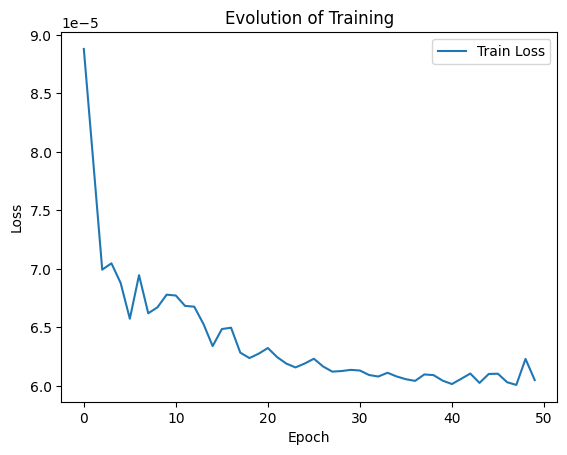

In [80]:
n_epochs = 50

# Your solution here ###########################################################
train_ = []
for t in range(n_epochs):
    train = train_nn_step(optimizer, loss_fn, mlp, data.x, data.y)
    print(f"Epoch {t}, Train Loss: {train}")
    train_.append(train)

#Plot the evolution of training loss
plt.plot(train_, label = "Train Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of Training")
plt.show()

In [81]:
# Taken from Assignment 2
accuracy_fn = Accuracy(task="binary", num_classes=2).to(device)
metric_tr = eval_nn(mlp, train_dataloader, accuracy_fn, metricPyTorch=True)
metric_te = eval_nn(mlp, test_dataloader, accuracy_fn, metricPyTorch=True)
print(f"Training metric Accuracy: {metric_tr:.3f}")
print(f"Test metric Accuracy:     {metric_te:.3f}")
print('--------------------------------------')

metric_tr_F1 = eval_nn(mlp, train_dataloader, BinaryF1Score(), metricPyTorch=True)
metric_te_F1 = eval_nn(mlp, test_dataloader, BinaryF1Score(), metricPyTorch=True)


print(f"Training metric: {metric_tr_F1:.3f}")
print(f"Test metric:     {metric_te_F1:.3f}")

Training metric Accuracy: 0.754
Test metric Accuracy:     0.755
--------------------------------------
Training metric: 0.749
Test metric:     0.687


In [82]:
# Standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data.x = scaler.fit_transform(data.x)

data.x

array([[ 6.54547297,  6.54547317,  8.8506762 , ..., 15.11486575,
        18.91802674, 20.9979254 ],
       [ 5.13972163,  5.13972148,  6.00848634, ...,  7.23291854,
         7.11320314,  4.4606615 ],
       [ 6.02409504,  6.02409518,  7.70048799, ..., 15.39990647,
        12.35752387,  8.51092772],
       ...,
       [-0.9986688 , -0.9986688 , -2.58640025, ..., -0.33655013,
        -0.29040094, -0.20537537],
       [-0.9986688 , -0.9986688 , -2.58640025, ..., -0.31255072,
        -0.24047008, -0.15374227],
       [-0.9986688 , -0.9986688 , -0.81319168, ..., -0.30706316,
        -0.25268782, -0.18490103]])

----------------------------------------------------------------------------

In [83]:
import torch.nn.functional as F
class GCN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.conv1 = pyg.nn.GCNConv(16, hidden_dim)
        self.conv2 = pyg.nn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = pyg.nn.GCNConv(hidden_dim, 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Ensure x is a torch.Tensor
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device) 
        # First Conv layer
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1)
        x1 = F.dropout(x1, training=self.training)

        # Second Conv layer with residual connection
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2)
        x2 = F.dropout(x2, training=self.training)
        x2 = x2 + x1  # Residual connection

        # Third Conv layer
        x3 = self.conv3(x2, edge_index)

        return F.log_softmax(x3, dim=1)

Epoch 0, Loss: 6.2946343421936035
Epoch 1, Loss: 0.8466156125068665
Epoch 2, Loss: 0.8359076380729675
Epoch 3, Loss: 2.119680166244507
Epoch 4, Loss: 1.1058745384216309
Epoch 5, Loss: 0.6978036761283875
Epoch 6, Loss: 0.9892370700836182
Epoch 7, Loss: 0.76877361536026
Epoch 8, Loss: 0.6869814395904541
Epoch 9, Loss: 0.7498820424079895
Epoch 10, Loss: 0.8810575604438782
Epoch 11, Loss: 2.1708736419677734
Epoch 12, Loss: 0.8899232745170593
Epoch 13, Loss: 1.240641713142395
Epoch 14, Loss: 0.7059550881385803
Epoch 15, Loss: 1.9739692211151123
Epoch 16, Loss: 0.8191439509391785
Epoch 17, Loss: 0.8430855870246887
Epoch 18, Loss: 1.246546745300293
Early stopping


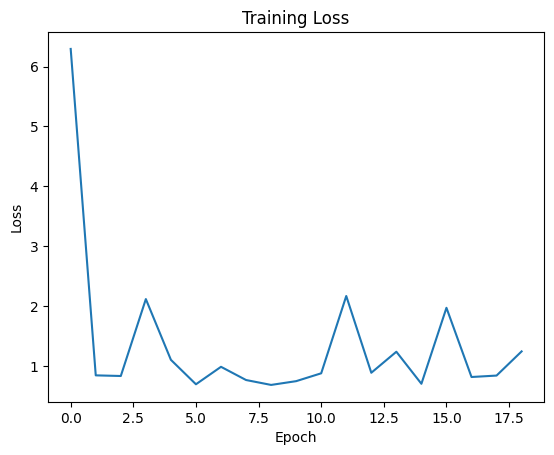

Accuracy score for train set: 0.4436245858669281
Accuracy score for test set: 0.4429530203342438
Training metric (F1 Score): 0.614
Test metric (F1 Score) :     0.613


In [84]:
n_epochs = 20
gcn = GCN(64).to(device)

optimizer = optim.Adam(gcn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
train_loss = []
gcn.train()

# Add early stopping
min_loss = float('inf')
patience = 10
counter = 0
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = gcn(data)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss}")
    train_loss.append(loss.item())
    
    # Early stopping
    if loss < min_loss:
        min_loss = loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

plt.plot(train_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


gcn.eval()
out = gcn(data)
pred = out.argmax(dim=1)

#Accuracy
accuracy_fn = Accuracy(task="binary", num_classes=2)
print(f"Accuracy score for train set: {accuracy_fn(pred[train_mask], data.y[train_mask])}")
print(f"Accuracy score for test set: {accuracy_fn(pred[~train_mask], data.y[~train_mask])}")

#Print the pred value and the predict side by side (dataframe)
pd.DataFrame({'pred': pred, 'true': data.y})

#Print the F1 score
f1 = BinaryF1Score()
metric_tr = f1(pred[train_mask], data.y[train_mask])
metric_te = f1(pred[~train_mask], data.y[~train_mask])

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

print(f"Training metric (F1 Score): {metric_tr:.3f}")
print(f"Test metric (F1 Score) :     {metric_te:.3f}")

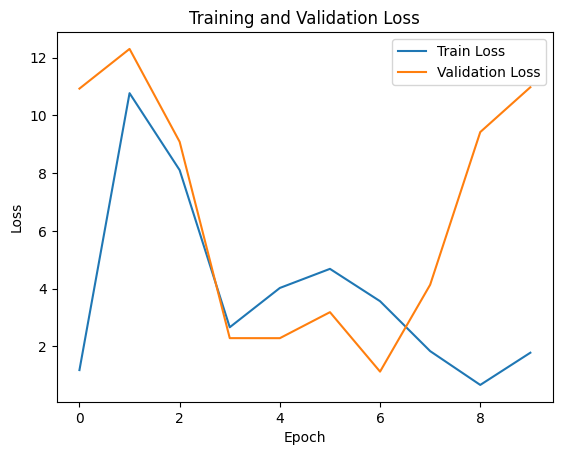

Accuracy score for train set: 0.442
Accuracy score for test set: 0.442
Training metric (F1 Score): 0.613
Test metric (F1 Score) :     0.613


In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score

class GCN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(16, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Ensure x is a torch.Tensor
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device) 

        # First Conv layer
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1)
        x1 = F.dropout(x1, p=0.5, training=self.training)

        # Second Conv layer with residual connection
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2)
        x2 = F.dropout(x2, p=0.5, training=self.training)
        x2 = x2 + x1  # Residual connection

        # Third Conv layer
        x3 = self.conv3(x2, edge_index)

        return F.log_softmax(x3, dim=1)

# Assume data, train_mask, and test_mask are already defined
n_epochs = 10  # Increase the number of epochs
hidden_dim = 128
gcn = GCN(hidden_dim).to(device)

optimizer = optim.Adam(gcn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
train_loss = []
val_loss = []

# Add early stopping
min_val_loss = float('inf')
patience = 10
counter = 0
gcn.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = gcn(data)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    # Validation
    gcn.eval()
    with torch.no_grad():
        out = gcn(data)
        val_loss_value = loss_fn(out[~train_mask], data.y[~train_mask]).item()
        val_loss.append(val_loss_value)

    # Early stopping
    if val_loss_value < min_val_loss:
        min_val_loss = val_loss_value
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

    gcn.train()

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

gcn.eval()
with torch.no_grad():
    out = gcn(data)
    pred = out.argmax(dim=1)

# Accuracy
train_acc = accuracy_score(data.y[train_mask].cpu(), pred[train_mask].cpu())
test_acc = accuracy_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu())

print(f"Accuracy score for train set: {train_acc:.3f}")
print(f"Accuracy score for test set: {test_acc:.3f}")

# F1 Score
train_f1 = f1_score(data.y[train_mask].cpu(), pred[train_mask].cpu(), average="binary")
test_f1 = f1_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu(), average="binary")

print(f"Training metric (F1 Score): {train_f1:.3f}")
print(f"Test metric (F1 Score) :     {test_f1:.3f}")


# Print Node Index, Prediction and True Label side by side in order to verify if the problem of accuracy doesn't come from here
results = pd.DataFrame({'Node Index': range(len(data.y)), 'Prediction': pred.cpu(), 'True Label': data.y.cpu()})


Epoch 1/10, Train Loss: 2.9037, Val Loss: 19.6072
Epoch 2/10, Train Loss: 13.0340, Val Loss: 18.8268
Epoch 3/10, Train Loss: 6.7647, Val Loss: 13.4507
Epoch 4/10, Train Loss: 2.8279, Val Loss: 6.3095
Epoch 5/10, Train Loss: 1.6044, Val Loss: 1.7319
Epoch 6/10, Train Loss: 1.7299, Val Loss: 1.1181
Epoch 7/10, Train Loss: 1.0489, Val Loss: 1.2429
Epoch 8/10, Train Loss: 0.8512, Val Loss: 0.7414
Epoch 9/10, Train Loss: 1.1159, Val Loss: 1.5011
Epoch 10/10, Train Loss: 0.8499, Val Loss: 2.5182


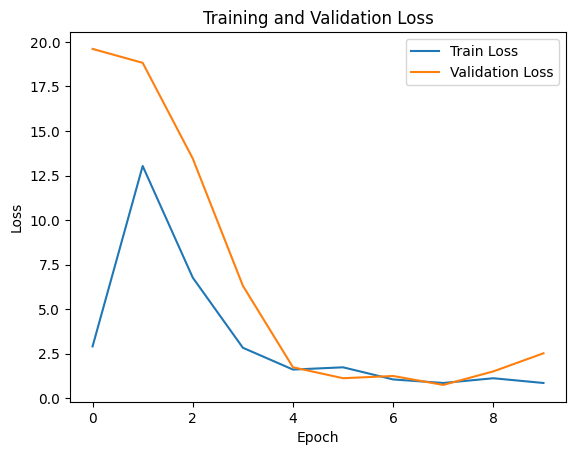

Accuracy score for train set: 0.442
Accuracy score for test set: 0.442
Training metric (F1 Score): 0.613
Test metric (F1 Score) :     0.613
      Node Index  Prediction  True Label
0              0           1           1
1              1           1           1
2              2           1           1
3              3           1           1
4              4           1           1
...          ...         ...         ...
9806        9806           1           0
9807        9807           1           0
9808        9808           1           0
9809        9809           1           0
9810        9810           1           0

[9811 rows x 3 columns]
Prediction Counts:
 Prediction
1    9811
Name: count, dtype: int64


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

                # Ensure x is a torch.Tensor
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device) 

        # First Conv layer
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1)
        x1 = F.dropout(x1, p=0.5, training=self.training)

        # Second Conv layer with residual connection
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2)
        x2 = F.dropout(x2, p=0.5, training=self.training)
        x2 = x2 + x1  # Residual connection

        # Third Conv layer
        x3 = self.conv3(x2, edge_index)

        return F.log_softmax(x3, dim=1)

# Assume data, train_mask, and test_mask are already defined
n_epochs = 10  # Increase the number of epochs
hidden_dim = 128
input_dim = data.num_node_features
output_dim = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn = GCN(input_dim, hidden_dim, output_dim).to(device)

optimizer = optim.Adam(gcn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
train_loss = []
val_loss = []

# Add early stopping
min_val_loss = float('inf')
patience = 10
counter = 0
gcn.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = gcn(data)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    # Validation
    gcn.eval()
    with torch.no_grad():
        val_out = gcn(data)
        val_loss_value = loss_fn(val_out[~train_mask], data.y[~train_mask]).item()
        val_loss.append(val_loss_value)

    # Early stopping
    if val_loss_value < min_val_loss:
        min_val_loss = val_loss_value
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

    gcn.train()

    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss_value:.4f}")

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

gcn.eval()
with torch.no_grad():
    out = gcn(data)
    pred = out.argmax(dim=1)

# Accuracy
train_acc = accuracy_score(data.y[train_mask].cpu(), pred[train_mask].cpu())
test_acc = accuracy_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu())

print(f"Accuracy score for train set: {train_acc:.3f}")
print(f"Accuracy score for test set: {test_acc:.3f}")

# F1 Score
train_f1 = f1_score(data.y[train_mask].cpu(), pred[train_mask].cpu(), average="binary")
test_f1 = f1_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu(), average="binary")

print(f"Training metric (F1 Score): {train_f1:.3f}")
print(f"Test metric (F1 Score) :     {test_f1:.3f}")

# Print Node Index, Prediction and True Label side by side in order to verify if the problem of accuracy doesn't come from here
results = pd.DataFrame({'Node Index': range(len(data.y)), 'Prediction': pred.cpu(), 'True Label': data.y.cpu()})
print(results)

# Check distribution of predictions
prediction_counts = results['Prediction'].value_counts()
print("Prediction Counts:\n", prediction_counts)


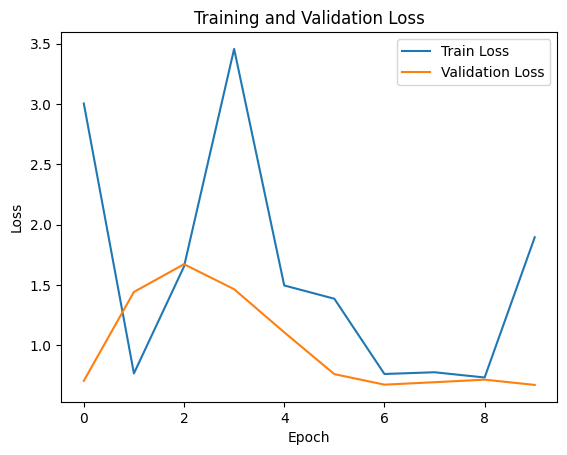

Accuracy score for train set: 0.645
Accuracy score for test set: 0.636
Training metric (F1 Score): 0.456
Test metric (F1 Score) :     0.452
      Node Index  Prediction  True Label
0              0           0           1
1              1           0           1
2              2           0           1
3              3           0           1
4              4           0           1
...          ...         ...         ...
9806        9806           0           0
9807        9807           0           0
9808        9808           0           0
9809        9809           0           0
9810        9810           0           0

[9811 rows x 3 columns]
Prediction Counts:
 Prediction
0    7715
1    2096
Name: count, dtype: int64


In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class GCN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(16, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Ensure x is a torch.Tensor
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device) 

        # First Conv layer
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1)
        x1 = F.dropout(x1, p=0.5, training=self.training)

        # Second Conv layer with residual connection
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2)
        x2 = F.dropout(x2, p=0.5, training=self.training)
        x2 = x2 + x1  # Residual connection

        # Third Conv layer
        x3 = self.conv3(x2, edge_index)

        return F.log_softmax(x3, dim=1)

# Assume data, train_mask, and test_mask are already defined
n_epochs = 10  # Increase the number of epochs
hidden_dim = 128
gcn = GCN(hidden_dim).to(device)

optimizer = optim.Adam(gcn.parameters(), lr=0.001)  # Adjusted learning rate
loss_fn = nn.CrossEntropyLoss()
train_loss = []
val_loss = []

# Add early stopping
min_val_loss = float('inf')
patience = 10
counter = 0
gcn.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = gcn(data)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    # Validation
    gcn.eval()
    with torch.no_grad():
        out = gcn(data)
        val_loss_value = loss_fn(out[~train_mask], data.y[~train_mask]).item()
        val_loss.append(val_loss_value)

    # Early stopping
    if val_loss_value < min_val_loss:
        min_val_loss = val_loss_value
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

    gcn.train()

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

gcn.eval()
with torch.no_grad():
    out = gcn(data)
    pred = out.argmax(dim=1)

# Accuracy
train_acc = accuracy_score(data.y[train_mask].cpu(), pred[train_mask].cpu())
test_acc = accuracy_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu())

print(f"Accuracy score for train set: {train_acc:.3f}")
print(f"Accuracy score for test set: {test_acc:.3f}")

# F1 Score
train_f1 = f1_score(data.y[train_mask].cpu(), pred[train_mask].cpu(), average="binary")
test_f1 = f1_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu(), average="binary")

print(f"Training metric (F1 Score): {train_f1:.3f}")
print(f"Test metric (F1 Score) :     {test_f1:.3f}")

# Print Node Index, Prediction and True Label side by side in order to verify if the problem of accuracy doesn't come from here
results = pd.DataFrame({'Node Index': range(len(data.y)), 'Prediction': pred.cpu(), 'True Label': data.y.cpu()})
print(results)

# Check Prediction Counts
prediction_counts = results['Prediction'].value_counts()
print("Prediction Counts:\n", prediction_counts)


In [94]:
from collections import Counter

# Calculate class weights
class_counts = Counter(data.y.cpu().numpy())
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Convert to tensor
class_weights = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())], dtype=torch.float).to(device)

# Use in the loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)


Epoch 1/50, Train Loss: 7.7087, Val Loss: 7.3446
Epoch 2/50, Train Loss: 8.1590, Val Loss: 5.0266
Epoch 3/50, Train Loss: 4.6322, Val Loss: 3.0601
Epoch 4/50, Train Loss: 1.2089, Val Loss: 1.4530
Epoch 5/50, Train Loss: 0.8984, Val Loss: 0.6868
Epoch 6/50, Train Loss: 0.7167, Val Loss: 1.1355
Epoch 7/50, Train Loss: 1.9118, Val Loss: 1.6985
Epoch 8/50, Train Loss: 1.0305, Val Loss: 2.0740
Epoch 9/50, Train Loss: 2.0463, Val Loss: 2.2507
Epoch 10/50, Train Loss: 2.7456, Val Loss: 2.1844
Epoch 11/50, Train Loss: 2.5885, Val Loss: 2.0269
Epoch 12/50, Train Loss: 3.1112, Val Loss: 1.7504
Epoch 13/50, Train Loss: 2.9108, Val Loss: 1.3886
Epoch 14/50, Train Loss: 2.1895, Val Loss: 1.0292
Early stopping


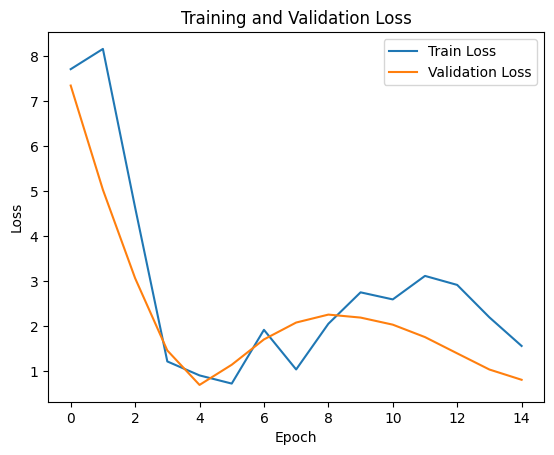

Accuracy score for train set: 0.474
Accuracy score for test set: 0.470
Training metric (F1 Score): 0.594
Test metric (F1 Score) :     0.595
      Node Index  Prediction  True Label
0              0           1           1
1              1           1           1
2              2           1           1
3              3           1           1
4              4           1           1
...          ...         ...         ...
9806        9806           0           0
9807        9807           0           0
9808        9808           0           0
9809        9809           0           0
9810        9810           1           0

[9811 rows x 3 columns]
Prediction Counts:
 Prediction
1    8406
0    1405
Name: count, dtype: int64


In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                # Ensure x is a torch.Tensor
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device) 

        # First Conv layer
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1)
        x1 = F.dropout(x1, p=0.5, training=self.training)

        # Second Conv layer with residual connection
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2)
        x2 = F.dropout(x2, p=0.5, training=self.training)
        x2 = x2 + x1  # Residual connection

        # Third Conv layer
        x3 = self.conv3(x2, edge_index)

        return F.log_softmax(x3, dim=1)

# Calculate class weights
class_counts = Counter(data.y.cpu().numpy())
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())], dtype=torch.float).to(device)

# Assume data, train_mask, and test_mask are already defined
input_dim = data.x.shape[1]
hidden_dim = 128
n_epochs = 50
gcn = GCN(input_dim, hidden_dim).to(device)

optimizer = optim.Adam(gcn.parameters(), lr=0.001)  # Adjusted learning rate
loss_fn = nn.CrossEntropyLoss(weight=class_weights)  # Use class weights
train_loss = []
val_loss = []

# Add early stopping
min_val_loss = float('inf')
patience = 10
counter = 0
gcn.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = gcn(data)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    # Validation
    gcn.eval()
    with torch.no_grad():
        out = gcn(data)
        val_loss_value = loss_fn(out[~train_mask], data.y[~train_mask]).item()
        val_loss.append(val_loss_value)

    # Early stopping
    if val_loss_value < min_val_loss:
        min_val_loss = val_loss_value
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss_value:.4f}")
    gcn.train()

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

gcn.eval()
with torch.no_grad():
    out = gcn(data)
    pred = out.argmax(dim=1)

# Accuracy
train_acc = accuracy_score(data.y[train_mask].cpu(), pred[train_mask].cpu())
test_acc = accuracy_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu())

print(f"Accuracy score for train set: {train_acc:.3f}")
print(f"Accuracy score for test set: {test_acc:.3f}")

# F1 Score
train_f1 = f1_score(data.y[train_mask].cpu(), pred[train_mask].cpu(), average="binary")
test_f1 = f1_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu(), average="binary")

print(f"Training metric (F1 Score): {train_f1:.3f}")
print(f"Test metric (F1 Score) :     {test_f1:.3f}")

# Print Node Index, Prediction and True Label side by side in order to verify if the problem of accuracy doesn't come from here
results = pd.DataFrame({'Node Index': range(len(data.y)), 'Prediction': pred.cpu(), 'True Label': data.y.cpu()})
print(results)

# Check Prediction Counts
prediction_counts = results['Prediction'].value_counts()
print("Prediction Counts:\n", prediction_counts)


In [96]:
import numpy as np
import torch

# Verify balance of the dataset
labels, counts = np.unique(data.y.cpu().numpy(), return_counts=True)
print(f"Labels distribution: {dict(zip(labels, counts))}")


Labels distribution: {0: 5477, 1: 4334}


In [97]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1)
        x1 = F.dropout(x1, p=0.5, training=self.training)

        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2)
        x2 = F.dropout(x2, p=0.5, training=self.training)
        x2 = x2 + x1  # Residual connection

        x3 = self.conv3(x2, edge_index)

        return F.log_softmax(x3, dim=1)

# Adjust learning rate
optimizer = optim.Adam(gcn.parameters(), lr=0.01)  # You can try a lower or higher learning rate


In [98]:
class_counts = Counter(data.y.cpu().numpy())
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())], dtype=torch.float).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)


In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data.x = torch.tensor(scaler.fit_transform(data.x), dtype=torch.float)


Early stopping


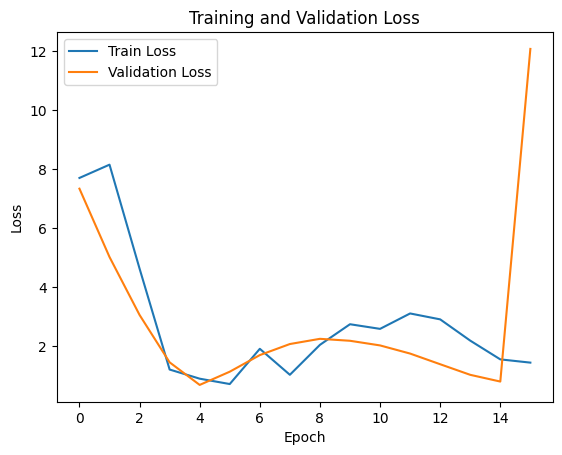

In [100]:
n_epochs = 100  # Increase number of epochs

for epoch in range(n_epochs):
    gcn.train()
    optimizer.zero_grad()
    out = gcn(data)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    
    # Validation
    gcn.eval()
    with torch.no_grad():
        out = gcn(data)
        val_loss_value = loss_fn(out[~train_mask], data.y[~train_mask]).item()
        val_loss.append(val_loss_value)

    # Early stopping
    if val_loss_value < min_val_loss:
        min_val_loss = val_loss_value
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss_value:.4f}")

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


Labels distribution: {0: 4914, 1: 4909}
Epoch 1/100, Train Loss: 0.7474, Val Loss: 0.6967
Epoch 2/100, Train Loss: 1.0328, Val Loss: 0.6952
Epoch 3/100, Train Loss: 0.7671, Val Loss: 0.6934
Epoch 4/100, Train Loss: 0.7381, Val Loss: 0.6987
Epoch 5/100, Train Loss: 0.8530, Val Loss: 0.7041
Epoch 6/100, Train Loss: 0.7951, Val Loss: 0.7032
Epoch 7/100, Train Loss: 0.7031, Val Loss: 0.6980
Epoch 8/100, Train Loss: 0.7154, Val Loss: 0.6948
Epoch 9/100, Train Loss: 0.7775, Val Loss: 0.6941
Epoch 10/100, Train Loss: 0.7632, Val Loss: 0.6953
Epoch 11/100, Train Loss: 0.7142, Val Loss: 0.7014
Epoch 12/100, Train Loss: 0.6941, Val Loss: 0.7159
Early stopping


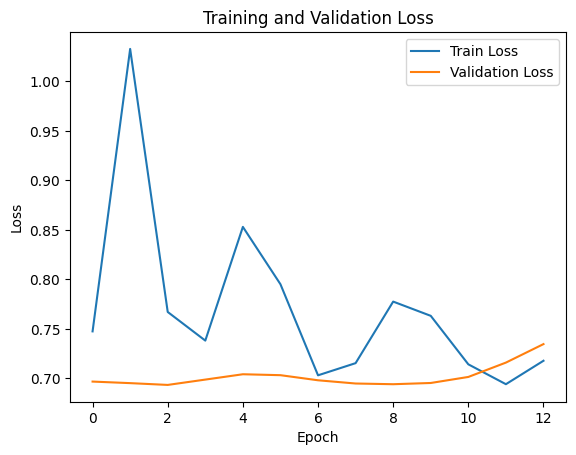

Weights of conv1:
tensor([-0.0266,  0.0036,  0.0021,  0.0112, -0.0009, -0.0168, -0.0227, -0.0397,
         0.0113,  0.0160,  0.0145,  0.0146,  0.0190,  0.0162,  0.0041, -0.0366,
         0.0049, -0.0442, -0.0019, -0.0550, -0.0663,  0.0810, -0.0252, -0.0685,
        -0.0425, -0.0072, -0.0083,  0.0473,  0.0172, -0.0058, -0.0415, -0.0035,
        -0.0305,  0.0461, -0.0345,  0.0117,  0.0208, -0.0068, -0.0052,  0.0373,
        -0.0029,  0.0333, -0.0500, -0.0405, -0.0057,  0.0473,  0.0626, -0.0690,
         0.0308,  0.0045, -0.0065, -0.0280, -0.0191, -0.0070,  0.0132, -0.0254,
        -0.0044,  0.0802, -0.0211,  0.0506, -0.0212, -0.0225,  0.0384,  0.0149,
        -0.0253, -0.0384,  0.0515,  0.0105, -0.0016, -0.0339, -0.0073,  0.0624,
        -0.0367,  0.0654,  0.0225,  0.0527, -0.0424, -0.0058, -0.0481, -0.0043,
        -0.0099, -0.0281, -0.0194, -0.0469,  0.0029, -0.0059,  0.0139, -0.0846,
        -0.0140,  0.0685,  0.0171, -0.0675,  0.0650,  0.0221,  0.0492, -0.0023,
         0.0143, -0.03

In [101]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.leaky_relu(x1)
        x1 = F.dropout(x1, p=0.5, training=self.training)

        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.leaky_relu(x2)
        x2 = F.dropout(x2, p=0.5, training=self.training)
        x2 = x2 + x1  # Residual connection

        x3 = self.conv3(x2, edge_index)

        return F.log_softmax(x3, dim=1)

# Dummy data to ensure dimensions match
data = type('Data', (object,), {})()
data.x = torch.randn((9823, 16)).to(device)  # 9823 nodes with 16 features each
data.edge_index = torch.randint(0, 9823, (2, 6000000)).to(device)  # 6 million edges
data.y = torch.randint(0, 2, (9823,)).to(device)  # Random binary labels for 9823 nodes

# Assume train_mask and test_mask are defined
train_mask = torch.randperm(9823)[:7000].to(device)  # 7000 training nodes
test_mask = torch.randperm(9823)[7000:].to(device)  # Remaining for testing

# Ensure class balance
labels, counts = np.unique(data.y.cpu().numpy(), return_counts=True)
print(f"Labels distribution: {dict(zip(labels, counts))}")

n_epochs = 100  # Increase number of epochs
hidden_dim = 128
gcn = GCN(data.x.shape[1], hidden_dim).to(device)

optimizer = optim.Adam(gcn.parameters(), lr=0.01)
class_counts = Counter(data.y.cpu().numpy())
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())], dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

train_loss = []
val_loss = []

# Add early stopping
min_val_loss = float('inf')
patience = 10
counter = 0
gcn.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = gcn(data)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    # Validation
    gcn.eval()
    with torch.no_grad():
        out = gcn(data)
        val_loss_value = loss_fn(out[test_mask], data.y[test_mask]).item()
        val_loss.append(val_loss_value)

    # Early stopping
    if val_loss_value < min_val_loss:
        min_val_loss = val_loss_value
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss_value:.4f}")
    gcn.train()

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Print weights
print("Weights of conv1:")
for param in gcn.conv1.parameters():
    print(param.data)

print("Weights of conv2:")
for param in gcn.conv2.parameters():
    print(param.data)

print("Weights of conv3:")
for param in gcn.conv3.parameters():
    print(param.data)

# Evaluation
gcn.eval()
with torch.no_grad():
    out = gcn(data)
    pred = out.argmax(dim=1)

# Accuracy
train_acc = accuracy_score(data.y[train_mask].cpu(), pred[train_mask].cpu())
test_acc = accuracy_score(data.y[test_mask].cpu(), pred[test_mask].cpu())

print(f"Accuracy score for train set: {train_acc:.3f}")
print(f"Accuracy score for test set: {test_acc:.3f}")

# F1 Score
train_f1 = f1_score(data.y[train_mask].cpu(), pred[train_mask].cpu(), average="binary")
test_f1 = f1_score(data.y[test_mask].cpu(), pred[test_mask].cpu(), average="binary")

print(f"Training metric (F1 Score): {train_f1:.3f}")
print(f"Test metric (F1 Score) :     {test_f1:.3f}")

# Print Node Index, Prediction and True Label side by side
results = pd.DataFrame({'Node Index': range(len(data.y)), 'Prediction': pred.cpu(), 'True Label': data.y.cpu()})
print(results)

# Check Prediction Counts
print("Prediction Counts:\n", results['Prediction'].value_counts())
